In [1]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import powerlaw

In [38]:
def mean_degree(g):
    degree = g.degree_distribution()
    
    return degree.mean

def mean_dist_node_pairs(g):
    return


def exp_power_law_degrees(g):
    degrees = g.degree(g.vs)
    fitted = ig.statistics.power_law_fit(degrees)
    
    return fitted.alpha, fitted.xmin, fitted.p

def exp_power_law_alternative(g):
    degrees = g.degree(g.vs)
    results = powerlaw.Fit(data)
    
    return results.power_law.alpha, results.power_law.xmin

def exp_power_law_strengths(g):
    """
    H0: data was drawn from the fitted distribution

    """
    strengths = g.strength(g.vs, weights=1/(1+np.array(g.es['weight'])))
    fitted = ig.statistics.power_law_fit(strengths)
    
    return fitted.alpha, fitted.xmin, fitted.p


def cluster_coeff(g):
    return g.transitivity_undirected()


def random_cluster_coeff(g):
    n = g.vcount()
    degrees = g.degree(g.vs, loops=False)
    unique_degrees, degree_freqs = np.unique(degrees, return_counts=True)
    prop_degrees = degree_freqs/n
    moment_1 = np.dot(unique_degrees, prop_degrees)
    moment_2 = np.dot(unique_degrees**2, prop_degrees)
    
    return (1/n) * ((moment_2 - moment_1)**2) / (moment_1**3)


def assortativity_degree(g):
    assortativity = g.assortativity_degree(directed=False)
    return assortativity


def modularity(g, cats):
    # Checar si este es con distancias o fuerzas
    mod = g.modularity(cats.tolist(), weights=1/(1+np.array(g.es['weight'])))
    return mod

def summary(result, results_model, model_name):
    if result[1] == -1:
        # No calcular si la matriz no tiene conexiones
        return
    
    y_pred = results_model['y_pred']
    
    summary_stats = {}
    summary_stats['modelo'] = model_name
    summary_stats['corte'] = result[0]
    summary_stats['global_efficiency'] = result[1]
    summary_stats['aristas'] = result[2]
    summary_stats['mean_degree'] = mean_degree(result[3])
    alpha, xmin, p = exp_power_law_degrees(result[3])
    summary_stats['pow_degree_alpha'] = alpha
    summary_stats['pow_degree_xmin'] = xmin
    summary_stats['pow_degree_p'] = p
    alpha, xmin, p = exp_power_law_strengths(result[3])
    summary_stats['pow_str_alpha'] = alpha
    summary_stats['pow_str_xmin'] = xmin
    summary_stats['pow_str_p'] = p
    summary_stats['cluster_coeff'] = cluster_coeff(result[3])
    summary_stats['modularity'] = modularity(result[3], y_pred)
    summary_stats['Assort. degree'] = assortativity_degree(result[3])
    
    return summary_stats

def summary_handler(rgraph_pkl, model_name):
    """
    Parameters
    ----------
    rgraph_pkl: str
        reduced graph file name
    model_name: str
        Model name
    """
    complete_path = reduced_graphs_path + '/' + rgraph_pkl
    results_graph = joblib.load(complete_path)    
    summary_stats = summary(results_graph, results_model, model_name)
    return summary_stats

def stats_by_model(model):
    """
    
    Parameters
    ----------
    model: str
        Path of model.pkl
    """
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
    results_model = joblib.load(model)
    
    ## Stats per cutoff
    stats_tmp = Parallel(n_jobs=5)(delayed(summary)(r, results_model, model_name) for r in results)
    
    return stats_tmp

def plot_codo_eff_global(results, ax=None):
    if ax is None:
        ax = plt.gca()
        
    g_efficiencies = pd.Series(list(zip(*results))[1])
    g_efficiencies.plot(ax=ax)
    ax.set_xticks(range(10));
    ax.set_xticklabels(np.array(range(1,11))/10);

In [4]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [5]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic1/models/RandomForestClassifier.pkl',
                './results/Basic1/models/LogisticRegression.pkl',
                './results/Basic1/models/LinearDiscriminantAnalysis.pkl'
               ]

## Main summary table

In [36]:
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]

    reduced_graphs_path = '{}/reduced_graphs/{}'.format(model_folder, model_name)
    reduced_graphs_pkl = os.listdir(reduced_graphs_path)
    results_model = joblib.load(model)
    
    data = Parallel(n_jobs=6)(delayed(summary_handler)(rgraph_pkl, model_name) for rgraph_pkl in reduced_graphs_pkl)
    data = list(filter(None, data)) # Some graphs are non-conected so summary returns None instead of a dict


stats_df = pd.DataFrame(data)

stats_df = (
    stats_df
    .set_index(['modelo', 'corte'])
    .sort_values('corte')
)

In [64]:
stats_df

global_efficiency  aristas  mean_degree  pow_degree_alpha  \
modelo   corte                                                              
best_xgb 0.07            0.021349     1574     1.046195          2.060056   
         0.16            0.990155    65238    43.361914         11.042972   
         0.34            2.091162  1063844   707.108009          8.180089   
         0.37            2.130182  1340523   891.008973        109.762395   
         0.46            2.224936  2168246  1441.173812         27.056236   
         0.49            2.236914  2418892  1607.771353         18.490021   

                pow_degree_xmin  pow_degree_p  pow_str_alpha  pow_str_xmin  \
modelo   corte                                                               
best_xgb 0.07               2.0      0.914447       2.204526      4.714141   
         0.16             222.0      0.805831       2.608211     58.523938   
         0.34            1128.0      0.004900       9.102575    940.735037   
         0.37            1835.0      1.000000       9.636966   1074.166102   
         0.46            2076.0      0.995092      31.590638   1570.357383   
         0.49            2118.0      0.484039      20.998416   1572.214330   

                   pow_str_p  cluster_coeff  modularity  Assort. degree  
modelo   corte                                                           
best_xgb 0.07   1.960841e-01       0.593463    0.068352        0.764752  
         0.16   2.998214e-07       0.589882    0.059887        0.683706  
         0.34   5.051800e-03       0.717559    0.048523        0.491023  
         0.37   8.528691e-04       0.751212    0.047979        0.510255  
         0.46   8.684414e-01       0.846940    0.045685        0.527773  
         0.49   2.676012e-01       0.857976    0.044596        0.446894

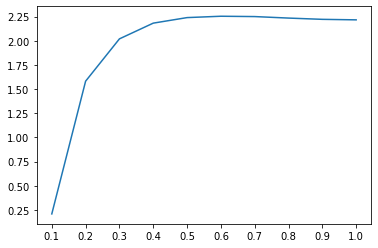

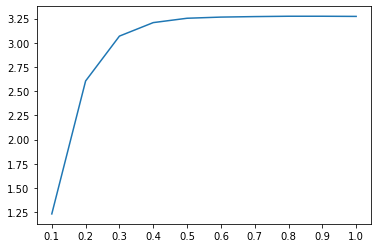

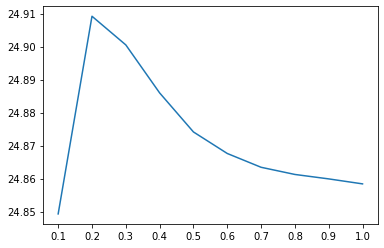

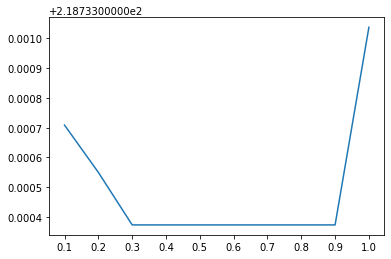

In [8]:
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))

    plot_codo_eff_global(results, ax=None)
    fig_name = '{}_codo.png'.format(model_name)
    fig_path = './results/figures/graphs/{}'.format(fig_name)
    plt.savefig(fig_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    
    # Escalar ejes

In [20]:
stats_total = []
for model in models_paths:
    stats_tmp = stats_by_model(model)
    stats_total = stats_total + stats_tmp
stats_df = pd.DataFrame(stats_total)
stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)

stats_df.loc[stats_df.pow_degree_p > .1, 'degree_sig'] = ''
stats_df.loc[stats_df.pow_degree_p < .1, 'degree_sig'] = '*'
stats_df.loc[stats_df.pow_degree_p < .05, 'degree_sig'] = '**'
stats_df.loc[stats_df.pow_degree_p < .01, 'degree_sig'] = '***'

stats_df.loc[stats_df.pow_str_p > .1, 'str_sig'] = ''
stats_df.loc[stats_df.pow_str_p < .1, 'str_sig'] = '*'
stats_df.loc[stats_df.pow_str_p < .05, 'str_sig'] = '**'
stats_df.loc[stats_df.pow_str_p < .01, 'str_sig'] = '***'

In [21]:
# Optimal
stats_df[stats_df['per_max_eff'] > .80].groupby('modelo').first()

,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,Assort. degree,per_max_eff,degree_sig,str_sig
modelo,,,,,,,,,,,,,,,,
LinearDiscriminantAnalysis,0.1,218.733709,4495830,2988.255234,3433.082018,2998.0,0.062053,7810.553682,2975.837119,0.010801,0.999675,0.000032,0.026077,0.999998,*,**
LogisticRegression,0.1,24.849282,2303025,1530.757727,391.758003,2251.0,0.986096,360.350586,2128.133390,0.840555,0.932081,0.000052,0.423752,0.997595,,
RandomForestClassifier,0.3,3.068783,1828590,1215.413759,44.945713,1977.0,0.259964,65.289675,1681.341876,0.754877,0.821960,0.001317,0.280315,0.937314,,
best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,0.213521,11.346527,770.011319,0.127554,0.689643,0.049384,0.510320,0.896160,,


In [22]:
# Tabla general
# Solo alrededor del corte optimo
# Modelo, submodelo por corte
stats_df

,modelo,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,Assort. degree,per_max_eff,degree_sig,str_sig
0,best_xgb,0.1,0.208811,8422,5.597873,2.132089,8.0,8.891367e-02,2.216093,11.024041,3.324355e-02,0.639503,0.065182,0.795471,0.092650,*,**
1,best_xgb,0.2,1.582012,170298,113.192423,7.769554,353.0,1.110526e-01,8.157067,314.951833,1.424846e-01,0.606946,0.051965,0.631632,0.701945,,
2,best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,2.135207e-01,11.346527,770.011319,1.275544e-01,0.689643,0.049384,0.510320,0.896160,,
3,best_xgb,0.4,2.182409,1624212,1079.569292,96.796118,1928.0,9.922593e-01,151.717687,1497.965549,9.828253e-01,0.789802,0.047496,0.541257,0.968344,,
4,best_xgb,0.5,2.239732,2498458,1660.656697,16.257166,2124.0,3.040092e-01,19.061300,1578.485341,3.134966e-01,0.858718,0.044277,0.411350,0.993779,,
5,best_xgb,0.6,2.253753,3336720,2217.826520,10.215240,2289.0,1.853580e-11,14.910005,1769.467694,8.869780e-10,0.865016,0.035984,0.105467,1.000000,***,***
6,best_xgb,0.7,2.250345,4079939,2711.823862,2018.838683,3006.0,8.560743e-01,19.106712,1885.521785,8.022725e-23,0.936249,0.022229,-0.025013,0.998488,,***
7,best_xgb,0.8,2.234777,4403302,2926.754403,12.060715,2706.0,0.000000e+00,146.927060,2129.450991,9.813211e-02,0.979242,0.012340,-0.052614,0.991580,***,*
8,best_xgb,0.9,2.221705,4512639,2999.427717,2111.528771,3007.0,0.000000e+00,759.288282,2158.226163,9.999990e-01,0.997340,0.008711,-0.025845,0.985780,***,
9,best_xgb,1.0,2.216418,4525536,3008.000000,9659.355375,3008.0,1.000000e+00,717.024242,2156.142704,9.999987e-01,1.000000,0.008450,NaN,0.983434,,
